In [1]:
import sys

sys.path.append("..")

from simulation_evaluation.microgrid_simulator import ControllEnvironment
from simulation_evaluation.microgrid_ga import MicrogridGA
from simulation_evaluation.controller_offline import SpaceShareController

day_nr=18
precision=1
battery_power=5.8
pv_scale=0.4
priorities=[1, 2, 3, 4, 5, 6, 7]

In [2]:
#Custom Utility Function
def evaluate_individual(individual):
    return sum(individual['Battery_SoC']) / 100.0 / 24.0

In [3]:
##Extending the GA with prorietary Utility Calculation
#Set Size and Generation Count
my_ga = MicrogridGA(2, 2,day_nr=day_nr, precision=precision, battery_power=battery_power, pv_scale=pv_scale,
                    priorities=priorities,step_type="percentage", mutate_chance=0.2, elit_perc=0.05)
#Redefine to new function
my_ga.evaluate_individual = evaluate_individual
my_ga.run()

🧬 GENERATION 0
Started:  2020-06-12 17:02:44.744951
Best Individual:  {'Nursery1_Lights_Quota': [0.1, 0.7, 0.0, 0.1, 0.6, 0.8, 0.0, 0.9, 0.3, 0.4, 0.5, 0.2, 0.6, 0.7, 0.1, 0.9, 0.0, 0.6, 0.6, 0.5, 0.7, 0.6, 0.4, 0.1], 'Nursery1_Sockets_Quota': [0.4, 1.0, 0.3, 0.7, 0.0, 0.0, 0.3, 0.8, 0.6, 0.6, 0.0, 0.2, 0.4, 0.3, 0.2, 0.5, 0.0, 1.0, 0.5, 0.6, 0.6, 0.4, 0.4, 0.8], 'Nursery2_Lights_Quota': [0.6, 0.9, 1.0, 0.5, 0.1, 0.9, 0.4, 0.4, 0.1, 0.6, 0.7, 0.6, 0.7, 0.3, 0.8, 0.2, 0.7, 0.6, 1.0, 0.8, 0.9, 0.1, 0.5, 0.1], 'Nursery2_Sockets_Quota': [0.4, 0.6, 0.7, 0.3, 0.7, 0.1, 0.5, 0.8, 0.4, 0.7, 0.5, 0.6, 0.3, 0.5, 0.4, 0.9, 0.5, 0.6, 0.7, 0.2, 0.5, 0.7, 0.2, 0.6], 'Playground_Lights_Quota': [0.1, 0.4, 0.3, 0.7, 0.6, 0.2, 0.3, 0.5, 0.4, 0.6, 0.7, 0.4, 0.6, 0.5, 0.9, 0.4, 0.4, 1.0, 0.7, 0.7, 0.6, 0.4, 0.5, 0.7], 'Playground_Sockets_Quota': [0.5, 0.9, 0.2, 0.7, 1.0, 0.4, 0.2, 0.1, 0.3, 0.3, 0.5, 1.0, 0.4, 0.0, 0.6, 0.1, 0.6, 0.6, 1.0, 0.7, 0.4, 0.6, 0.6, 0.8], 'Streetlights_Quota': [0.2, 0.7, 0.8, 0.

In [4]:
#Basic Controller Run
space_shared_controller = SpaceShareController(day_nr=day_nr, precision=precision, battery_power=battery_power, 
                                               pv_scale=pv_scale,priorities=priorities)

#Utility is only used to calculate final result with this methid
space_shared_controller.evaluate_individual = evaluate_individual
spaceshared_util = space_shared_controller.run()

-------Energy State--------
Generated energy: 2230.2661042700174
System Load: 2869.5698831237137
Battery SoC: 95.34561781609194
Remaining Energy: 1675.8234945215604
Priorities:  {1: 'Nursery1_Lights_Quota', 2: 'Nursery1_Sockets_Quota', 3: 'Nursery2_Lights_Quota', 4: 'Nursery2_Sockets_Quota', 5: 'Playground_Lights_Quota', 6: 'Playground_Sockets_Quota', 7: 'Streetlights_Quota'}
------------------------------------------------
For Device: Nursery1_Lights_Quota with energy avialable: 1675.8234945215604
Used Energy:  221.1207786075036
Remaining Energy:  1454.7027159140569
Result: 1454.7027159140569 Fraction:  1.0
------------------------------------------------
For Device: Nursery1_Sockets_Quota with energy avialable: 1454.7027159140569
Used Energy:  0.0
Remaining Energy:  1454.7027159140569
Result: 1454.7027159140569 Fraction:  1.0
------------------------------------------------
For Device: Nursery2_Lights_Quota with energy avialable: 1454.7027159140569
Used Energy:  424.62629973359975
Re

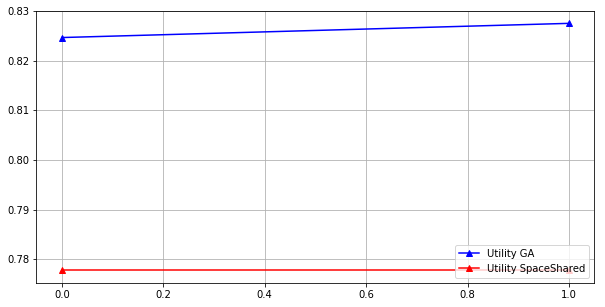

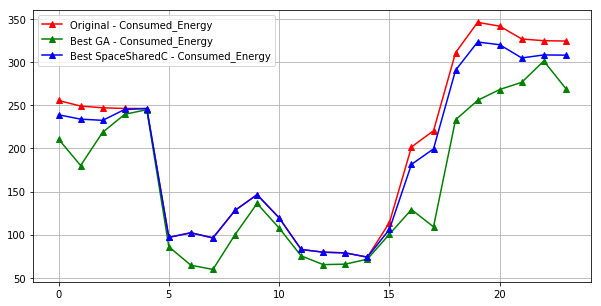

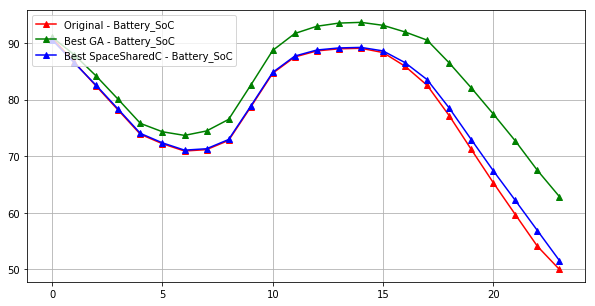

In [5]:
import pandas as pd
import random
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

ga_orig_indi = my_ga.get_original()
ga_best_indi = my_ga.get_deployed_best()

spaceshare_indi = space_shared_controller.get_deployment()

f_size = (10,5)
fig,ax = plt.subplots(1,1,figsize=f_size)
ax.plot([my_ga.history[x][0] for x in my_ga.history],'b-^',label="Utility GA")
ax.plot([spaceshared_util for x in my_ga.history],'r-^',label="Utility SpaceShared")
ax.legend(loc="lower right")
ax.grid()
plt.show()

parameters = ["Consumed_Energy","Battery_SoC"]
for p in parameters:    
    fig,ax = plt.subplots(1,1,figsize=f_size)
    ax.plot(ga_orig_indi.index,ga_orig_indi[p],'r-^', label="Original - "+p)
    ax.plot(ga_best_indi.index,ga_best_indi[p],'g-^',label="Best GA - "+p)
    ax.plot(spaceshare_indi.index,spaceshare_indi[p],'b-^',label="Best SpaceSharedC - "+p)
    ax.legend(loc="upper left")
    ax.grid()
    plt.show()